# Fantasy Basketball Optimization

### 1) Import Hashtag Basketball data and clean

In [39]:
import pandas as pd
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np
import itertools

# download and data cleaning
df = pd.read_csv('~/Desktop/hashtag_basketball_current.csv')
df = df[df['R#'] != 'R#']
df[['FGP', 'FGM', 'FGA']] = df['FG%'].str.replace(' ', '').str.split('[ \(/\)]', expand=True)[[0, 1, 2]]
df[['FTP', 'FTM', 'FTA']] = df['FT%'].str.replace(' ', '').str.split('[ \(/\)]', expand=True)[[0, 1, 2]]
df = df.drop(['FG%', 'FT%'], axis=1).rename(columns={'FGP': 'FG%', 'FTP': 'FT%', 'TREB': 'REB', 'TO': 'TOV', 'PLAYER': 'Name'})
df.Name = df.Name.str.strip().str.replace('[^\x00-\x7F]+', '')
df = df.reset_index(drop=True)

### 2) Create Z-Scores from CATs

In [40]:
# calculate auxiliary position and z-score columns
for pos in ['PG', 'PF', 'SG', 'SF', 'C', 'G', 'F']:
    df[pos] = df.POS.str.contains(pos).astype(int)
for col in ['3PM', 'REB', 'AST', 'STL', 'BLK', 'TOV', 'PTS', 'FGM', 'FGA', 'FTM', 'FTA']:
    df[col] = df[col].astype(float)
df['TOV'] = -1.0 * df['TOV']

# difference between shots made assuming league average and actual shots made
avg_fg = df['FGM'].mean() / df['FGA'].mean()
avg_ft = df['FTM'].mean() / df['FTA'].mean()
df['FGC'] = df['FGM'] - df['FGA'] * avg_fg
df['FTC'] = df['FTM'] - df['FTA'] * avg_ft

# get z-scores
for col in ['3PM', 'REB', 'AST', 'STL', 'BLK', 'TOV', 'PTS', 'FGC', 'FTC']:
    df[col + 'z'] = (df[col] - df[col].mean()) / df[col].std()

### 3) Specify players and CATs to consider

In [41]:
players = [
    'Collin Sexton',
    'Jordan Clarkson',
    'LaMelo Ball',
    'Harrison Barnes',
    'Robert Covington',
    'OG Anunoby',
    'Rudy Gobert', 
    'Deandre Ayton', 
    'Hassan Whiteside', 
    'Mitchell Robinson', 
    'Will Barton', 
    'Derrick Rose',
    'Moritz Wagner'
]
CATS = ['REBz', 'STLz', 'BLKz', 'TOVz', 'FGCz', 'PTSz', 'ASTz', 'FTCz', '3PMz']

### 4) (Optional) Visualize player list in 2D-CAT space

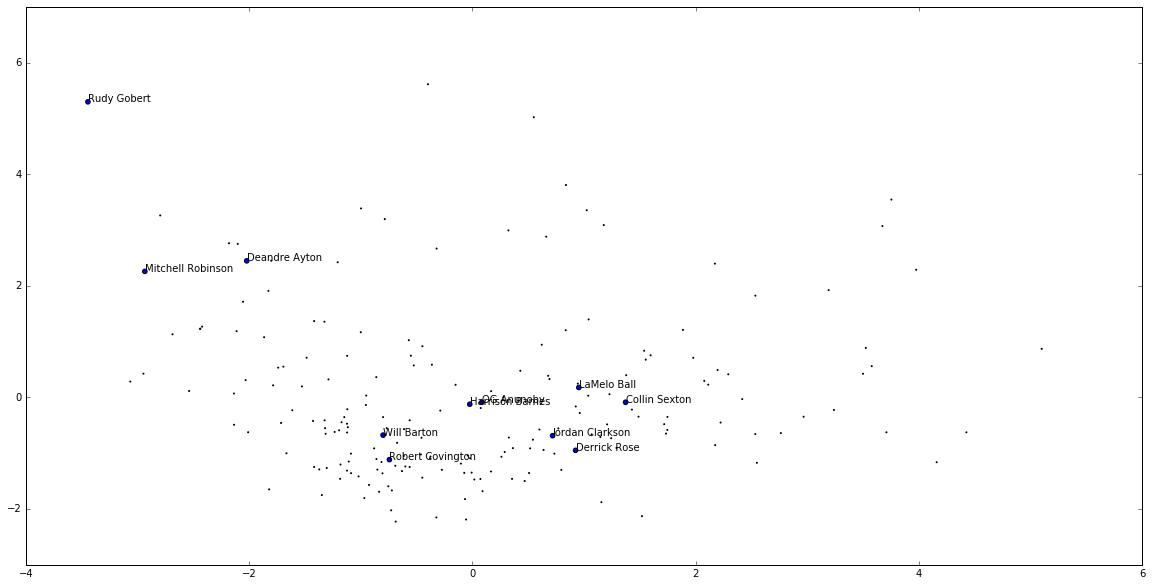

In [45]:
# do PCA to visualize z-scores
X = df[CATS].values

pca = PCA(n_components=2)
pca.fit(X)
X_new = pca.transform(X)

%matplotlib inline
fig, ax = plt.subplots(figsize=(20, 10))
ax.scatter(X_new[:, 0], X_new[:, 1], s=(1 + 20*(df.Name.isin(players)).astype(int)))

idx = df[df.Name.isin(players)].index.tolist()
for row in idx:
    ax.annotate(df.loc[row, 'Name'], (X_new[row, 0], X_new[row, 1]))

# Solve Integer Programming Problem
maximize 5th best cat by z-score

subject to:
1. 10 players max
2. At least 1 PG, SG, SF, PF, C
3. At least 2 C
4. At least 3 G, F


In [5]:
df['AVGz'] = df[CATS].mean(axis=1)
A = df.loc[df.Name.isin(players), CATS].T.values
P = df.loc[df.Name.isin(players), ['PG', 'PF', 'SG', 'SF', 'C', 'G', 'F']].T.values
max_combo, max_combo_val, max_combo_vec = 0, 0, 0

for combo in itertools.combinations(range(A.shape[1]), 10):
    x = np.zeros((A.shape[1], 1))
    x[combo, 0] = 1
    
    if not np.dot(P[0], x) >= 1:
        continue
    if not np.dot(P[1], x) >= 1:
        continue
    if not np.dot(P[2], x) >= 1:
        continue
    if not np.dot(P[3], x) >= 1:
        continue
    if not np.dot(P[4], x) >= 2:
        continue
    if not np.dot(P[5], x) >= 3:
        continue
    if not np.dot(P[6], x) >= 3:
        continue

    
    val = sorted(np.dot(A, x), reverse=True)[4][0]
    if val > max_combo_val:
        max_combo_val = val
        max_combo_vec = np.dot(A, x)
        max_combo = combo
        
for idx, cat in enumerate(CATS):
    print("{}: {}".format(cat, max_combo_vec[idx]))
print("5th Best={}".format(max_combo_val))
print("TOP 10 Players")
df.loc[df.Name.isin(players), ['Name'] + CATS].iloc[list(max_combo)]

REBz: [ 5.58108321]
STLz: [ 3.83756153]
BLKz: [ 4.06343377]
TOVz: [ 2.10641255]
FGCz: [ 2.52672143]
PTSz: [-1.57697192]
ASTz: [-3.75103353]
FTCz: [-6.32864493]
3PMz: [-3.00106357]
5th Best=2.10641255026
TOP 10 Players


,Name,REBz,STLz,BLKz,TOVz,FGCz,PTSz,ASTz,FTCz,3PMz
40,Collin Sexton,-1.275759,0.939924,-0.578731,-0.327607,1.502348,1.708561,0.099245,0.299997,0.365709
60,Mitchell Robinson,1.050500,1.162392,2.235768,1.018013,1.540730,-0.950615,-1.282351,-1.265370,-1.592571
61,Jordan Clarkson,-0.306485,0.050055,-0.578731,-0.224097,0.487512,0.483728,-0.683660,0.626147,1.344849
72,OG Anunoby,-0.035088,2.497196,-0.051013,0.086430,-0.198747,-0.225385,-0.729713,-0.482687,0.365709
75,Rudy Gobert,3.144133,-1.062282,3.643018,-0.017079,1.270078,-0.370431,-0.867873,-3.970595,-1.592571
80,LaMelo Ball,0.585248,1.162392,-0.402825,-0.327607,-1.053790,-0.402664,1.296628,-0.453328,-0.025947
85,Harrison Barnes,0.391393,-0.617347,-0.754638,0.293449,0.275928,0.306450,-0.038915,0.404354,-0.221775
92,Deandre Ayton,2.252400,-1.507216,0.652612,0.086430,1.321012,-0.322083,-0.683660,-0.795760,-1.494657
150,Will Barton,-0.422798,0.272522,0.124893,0.914504,-0.936797,-0.515477,-0.177075,-0.754991,-0.123861
178,Robert Covington,0.197538,0.939924,-0.226919,0.603976,-1.681552,-1.289056,-0.683660,0.063589,-0.025947
